# Imports

In [86]:

import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants
import random
importlib.reload(constants)
from constants import *

nest.set_verbosity("M_ERROR") # SHUT UP NEST
nest.ResetKernel()

# Functions

## Setup

In [87]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN,
        "a": ADAPTATION_a,         
        "b": ADAPTATION_b,         
        "tau_w": ADAPTATION_tau_w  
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN,
        "I_e": INH_BACKGROUND
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I

    nest.CopyModel("aeif_cond_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    defaults = nest.GetDefaults("inh_iaf_psc_alpha")
    print("Receptor types:", defaults.get("receptor_types", "No receptor_types entry found"))

    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def connect_pop_base(layer_e, layer_i):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """

    # Define a distance‐dependent connection rule
    distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, std=GAUSSIAN_STD)
    conndict = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution > DISTRIBUTION_THRESHOLD, distribution, 0),
        "mask": {"circular": {"radius": MASK_RADIUS}},
    }

    syn_params = {
        "U": 0.05,
        "u": 0.0,
        "tau_rec": 1000.0,
        "tau_fac": 400.0,
        "weight" : EXC_WEIGHT
    }

    # Copy a generic synapse model
    nest.CopyModel("tsodyks_synapse", "synapse", syn_params)

    static_inh_params = {
        "weight": INH_WEIGHT,  
        "delay": DELAY_CONNECTION 
    }
    nest.CopyModel("static_synapse", "inhibitory_synapse", static_inh_params)
    # Define weights
    # exc_weight = EXC_WEIGHT
    # inh_weight = INH_WEIGHT

    # Make connections
    nest.Connect(layer_e, layer_i, conndict, syn_spec={"synapse_model": "synapse"})
    nest.Connect(layer_i, layer_e, conndict, syn_spec={"synapse_model": "inhibitory_synapse"})
    nest.Connect(layer_e, layer_e, conndict, syn_spec={"synapse_model": "synapse"})
    nest.Connect(layer_i, layer_i, conndict, syn_spec={"synapse_model": "inhibitory_synapse"})

    connections_exc = nest.GetConnections(synapse_model="synapse")
    connections_inh = nest.GetConnections(synapse_model="inhibitory_synapse")
    print("Number of excitatory connections: ", len(connections_exc))
    print("Number of inhibitory connections: ", len(connections_inh))

def create_thalamic_input(layer_e):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": THALAMIC_INPUT_FIRING_RATE})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": THALAMIC_INPUT_WEIGHT, "delay": THALAMIC_INPUT_DELAY}) 
    return thalamic_input

## Monitoring

In [88]:
def recording_devices(layer_e, layer_i, input):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    sr_i = nest.Create("spike_recorder")
    sr_input = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    nest.Connect(layer_i, sr_i)
    nest.Connect(input, sr_input)

    multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e)
    nest.Connect(multimeter_i, layer_i)
    
    return multimeter_e, multimeter_i, sr_e, sr_i, sr_input

def plot_spikes(sr_e, sr_i, sr_input):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    # poisson generator
    spike_events_input = nest.GetStatus(sr_input, "events")[0]
    # print(spike_events_input)
    senders_input = spike_events_input["senders"]
    times_input = spike_events_input["times"]

    dots_size = 3

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(times_e, senders_e, s=dots_size, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=dots_size, label="Inhibitory", color="blue")
    ax.scatter(times_input, senders_input, s=dots_size, label="Input", color="orange")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_voltages(multimeter_e, multimeter_i):
    multimeter_events_e = nest.GetStatus(multimeter_e, "events")[0]
    multimeter_events_i = nest.GetStatus(multimeter_i, "events")[0]

    times_e = multimeter_events_e["times"]
    voltages_e = multimeter_events_e["V_m"]
    times_i = multimeter_events_i["times"]
    voltages_i = multimeter_events_i["V_m"]

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(times_e, voltages_e, label="Excitatory", color="red")
    ax.plot(times_i, voltages_i, label="Inhibitory", color="blue")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Membrane potential (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Monitoring Synapses Evolution

The following code:

1. splits the connections in exc-exc, exc-inh, inh-exc, inh-inh
2. simulate for each step for an amount of time defined by step_duration, for each steps it retrieves u and x values for each type of connection
3. plots with two scatter plots the progression of each type

In [89]:
# SETUP NETWORK
nest.ResetKernel()
layer_e, layer_i = create_populations()
connect_pop_base(layer_e, layer_i)
input = create_thalamic_input(layer_e)
_, _, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)

Receptor types: No receptor_types entry found
Number of excitatory connections:  18788
Number of inhibitory connections:  9623


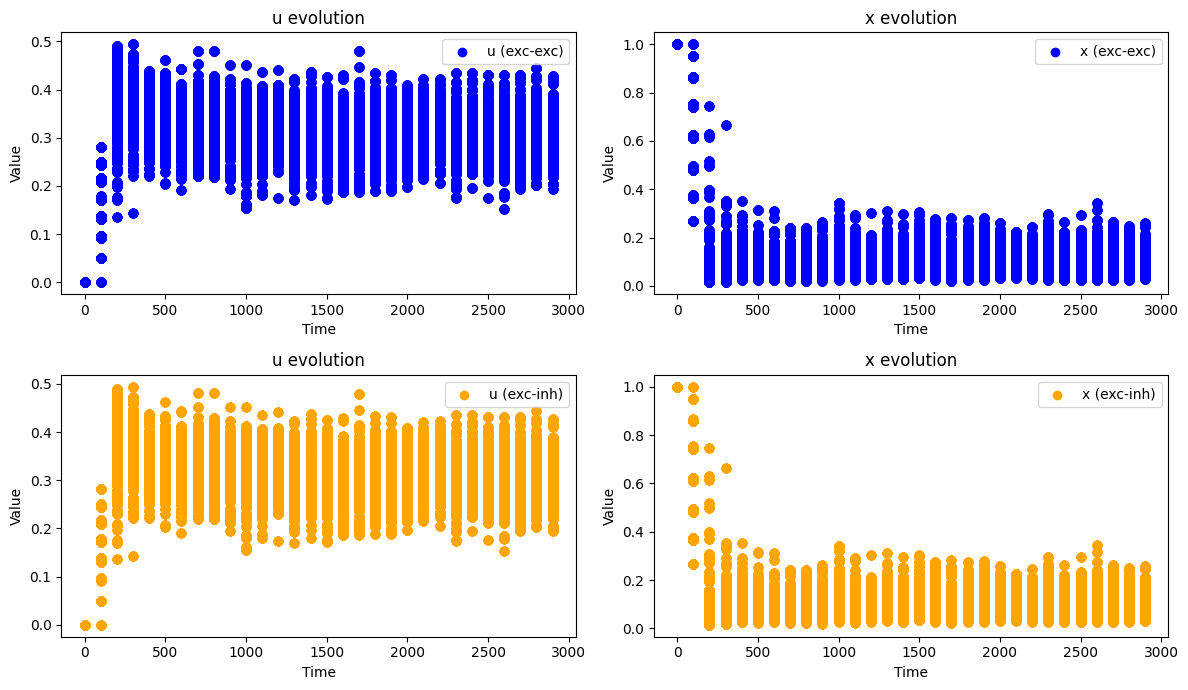

In [90]:
# GET SOME CONNECTIONS TO PLOT
exc_exc = nest.GetConnections(source=layer_e, target=layer_e, synapse_model="synapse")
exc_inh = nest.GetConnections(source=layer_e, target=layer_i, synapse_model="synapse")
inh_exc = nest.GetConnections(source=layer_i, target=layer_e, synapse_model="synapse")
inh_inh = nest.GetConnections(source=layer_i, target=layer_i, synapse_model="synapse")
steps = 30
step_duration = 100
time = 0

# initialization
u_values_exc_exc, u_values_exc_inh, u_values_inh_exc, u_values_inh_inh = [], [], [], []
x_values_exc_exc, x_values_exc_inh, x_values_inh_exc, x_values_inh_inh = [], [], [], []

timesteps = [step_duration*step for step in range(steps)]

for i in range(steps):
    # Retrieve u and x Values
    u_values_exc_exc.append(nest.GetStatus(exc_exc, "u"))
    u_values_exc_inh.append(nest.GetStatus(exc_inh, "u"))
    u_values_inh_exc.append(nest.GetStatus(inh_exc, "u"))
    u_values_inh_inh.append(nest.GetStatus(inh_inh, "u"))

    x_values_exc_exc.append(nest.GetStatus(exc_exc, "x"))
    x_values_exc_inh.append(nest.GetStatus(exc_inh, "x"))
    x_values_inh_exc.append(nest.GetStatus(inh_exc, "x"))
    x_values_inh_inh.append(nest.GetStatus(inh_inh, "x"))
    time += step_duration
    nest.Simulate(step_duration)

u_exc_exc_flattened = np.concatenate(u_values_exc_exc)
u_exc_inh_flattened = np.concatenate(u_values_exc_inh)
u_inh_exc_flattened = np.concatenate(u_values_inh_exc)
u_inh_inh_flattened = np.concatenate(u_values_inh_inh)
x_exc_exc_flattened = np.concatenate(x_values_exc_exc)
x_exc_inh_flattened = np.concatenate(x_values_exc_inh)
x_inh_exc_flattened = np.concatenate(x_values_inh_exc)
x_inh_inh_flattened = np.concatenate(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

axes[0,0].scatter(np.repeat(timesteps, len(u_values_exc_exc[0])), u_exc_exc_flattened, color="blue", label="u (exc-exc)")
axes[1,0].scatter(np.repeat(timesteps, len(u_values_exc_inh[0])), u_exc_inh_flattened, color="orange", label="u (exc-inh)")
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_exc[0])), u_inh_exc_flattened, color="green", label="u (inh-exc)", alpha=0.8)
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_inh[0])), u_inh_inh_flattened, color="purple", label="u (inh-inh)", alpha=0.1)
axes[0,1].scatter(np.repeat(timesteps, len(x_values_exc_exc[0])), x_exc_exc_flattened, color="blue", label="x (exc-exc)")
axes[1,1].scatter(np.repeat(timesteps, len(x_values_exc_inh[0])), x_exc_inh_flattened, color="orange", label="x (exc-inh)")
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_exc[0])), x_inh_exc_flattened, color="green", label="x (inh-exc)", alpha=0.7)
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_inh[0])), x_inh_inh_flattened, color="purple", label="x (inh-inh)", alpha=0.7)

axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].set_title("u evolution")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].set_title("u evolution")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].set_title("x evolution")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].set_title("x evolution")
axes[0,0].legend()
axes[1,0].legend()
axes[0,1].legend()
axes[1,1].legend()
plt.tight_layout()
plt.show()

## Mean + STD

In the following i take the above measure and plot a summary of the values with mean and std

/home/antonello03/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:Mean of empty slice.
/home/antonello03/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
/home/antonello03/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning:Degrees of freedom <= 0 for slice
/home/antonello03/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning:invalid value encountered in divide
/home/antonello03/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning:invalid value encountered in scalar divide


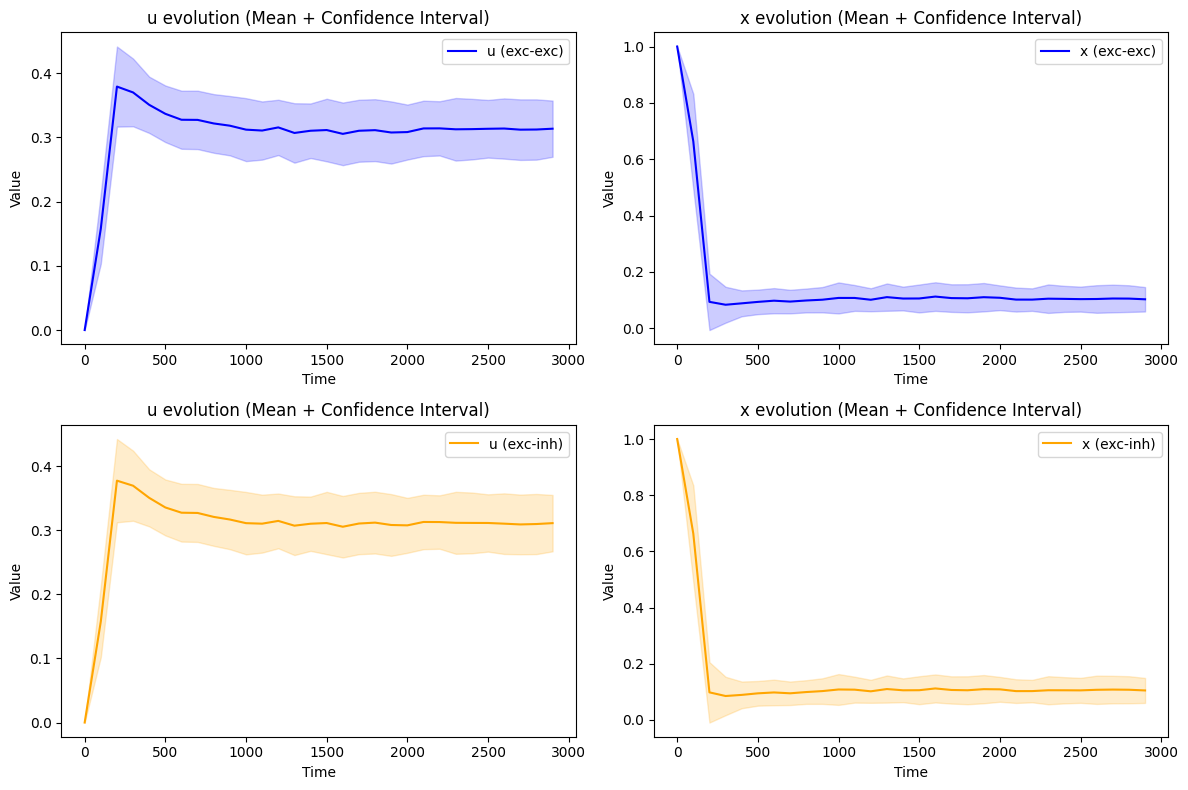

In [91]:
# Compute mean and standard deviation for confidence intervals
def compute_stats(values_list):
    means = [np.mean(values) for values in values_list]
    stds = [np.std(values) for values in values_list]
    return np.array(means), np.array(stds)

# Compute stats for u values
u_exc_exc_mean, u_exc_exc_std = compute_stats(u_values_exc_exc)
u_exc_inh_mean, u_exc_inh_std = compute_stats(u_values_exc_inh)
u_inh_exc_mean, u_inh_exc_std = compute_stats(u_values_inh_exc)
u_inh_inh_mean, u_inh_inh_std = compute_stats(u_values_inh_inh)

# Compute stats for x values
x_exc_exc_mean, x_exc_exc_std = compute_stats(x_values_exc_exc)
x_exc_inh_mean, x_exc_inh_std = compute_stats(x_values_exc_inh)
x_inh_exc_mean, x_inh_exc_std = compute_stats(x_values_inh_exc)
x_inh_inh_mean, x_inh_inh_std = compute_stats(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Line plot for u values with confidence interval
axes[0,0].plot(timesteps, u_exc_exc_mean, color="blue", label="u (exc-exc)")
axes[0,0].fill_between(timesteps, u_exc_exc_mean - u_exc_exc_std, u_exc_exc_mean + u_exc_exc_std, color="blue", alpha=0.2)
axes[1,0].plot(timesteps, u_exc_inh_mean, color="orange", label="u (exc-inh)")
axes[1,0].fill_between(timesteps, u_exc_inh_mean - u_exc_inh_std, u_exc_inh_mean + u_exc_inh_std, color="orange", alpha=0.2)
# axes[0].plot(timesteps, u_inh_exc_mean, color="green", label="u (inh-exc)")
# axes[0].fill_between(timesteps, u_inh_exc_mean - u_inh_exc_std, u_inh_exc_mean + u_inh_exc_std, color="green", alpha=0.2)
# axes[0].plot(timesteps, u_inh_inh_mean, color="purple", label="u (inh-inh)")
# axes[0].fill_between(timesteps, u_inh_inh_mean - u_inh_inh_std, u_inh_inh_mean + u_inh_inh_std, color="purple", alpha=0.2)
axes[0,0].set_title("u evolution (Mean + Confidence Interval)")
axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].legend()
axes[1,0].set_title("u evolution (Mean + Confidence Interval)")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].legend()

# Line plot for x values with confidence interval
axes[0,1].plot(timesteps, x_exc_exc_mean, color="blue", label="x (exc-exc)")
axes[0,1].fill_between(timesteps, x_exc_exc_mean - x_exc_exc_std, x_exc_exc_mean + x_exc_exc_std, color="blue", alpha=0.2)
axes[1,1].plot(timesteps, x_exc_inh_mean, color="orange", label="x (exc-inh)")
axes[1,1].fill_between(timesteps, x_exc_inh_mean - x_exc_inh_std, x_exc_inh_mean + x_exc_inh_std, color="orange", alpha=0.2)
# axes[1].plot(timesteps, x_inh_exc_mean, color="green", label="x (inh-exc)")
# axes[1].fill_between(timesteps, x_inh_exc_mean - x_inh_exc_std, x_inh_exc_mean + x_inh_exc_std, color="green", alpha=0.2)
# axes[1].plot(timesteps, x_inh_inh_mean, color="purple", label="x (inh-inh)")
# axes[1].fill_between(timesteps, x_inh_inh_mean - x_inh_inh_std, x_inh_inh_mean + x_inh_inh_std, color="purple", alpha=0.2)
axes[0,1].set_title("x evolution (Mean + Confidence Interval)")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].legend()
axes[1,1].set_title("x evolution (Mean + Confidence Interval)")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].legend()

plt.tight_layout()
plt.show()


# Spikes

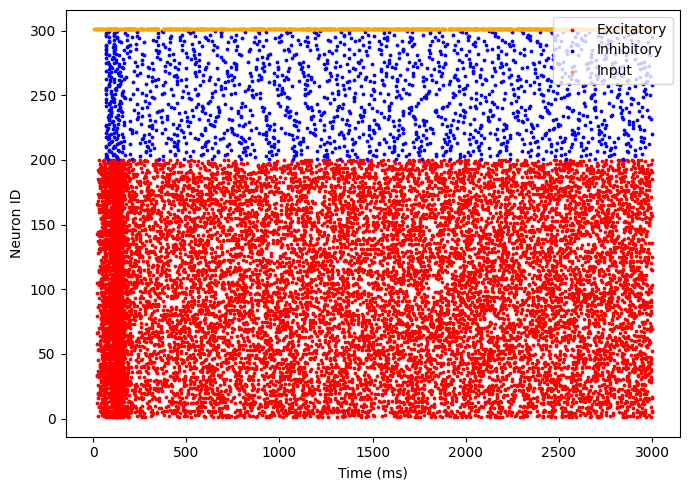

In [92]:
plot_spikes(sr_e, sr_i, sr_input)

# Simulation

In [93]:
# nest.set_verbosity("M_ERROR") # nest shut up

# nest.ResetKernel()

# layer_e, layer_i = create_populations()
# connect_pop_base(layer_e, layer_i)
# input = create_thalamic_input(layer_e)

# multimeter_e, multimeter_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)

# # Run simulation (adjust simulation time as needed)
# nest.Simulate(1000.0)

In [94]:
# # Plot outputs
# plot_spikes(sr_e, sr_i, sr_input)
# plot_voltages(multimeter_e, multimeter_i)
# multimeter_e_events = nest.GetStatus(multimeter_e, "events")[0]
# print(multimeter_e_events)